In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-23 00:17:34.998575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-23 00:17:34.998614: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
from sklearn.decomposition import PCA

dataset_name = 'BrainChromatin'
modality_names = ['RNA', 'ATAC']
data1 = pd.read_csv("../data/brainchromatin/multiome_rna_counts.tsv", delimiter='\t').transpose()
# PCA
# proc = PCA(n_components=32).fit_transform(data1)
# d1 = pd.DataFrame(proc)
# d1.index = data1.index
# data1 = d1

data2 = pd.read_csv("../data/brainchromatin/multiome_atac_gene_activities.tsv", delimiter='\t', nrows=35000).transpose()  # Only a subset
# PCA
# proc = PCA(n_components=32).fit_transform(data2)
# d2 = pd.DataFrame(proc)
# d2.index = data2.index
# data2 = d2
data2 = data2.transpose()[data1.index].transpose()

meta = pd.read_csv("../data/brainchromatin/multiome_cell_metadata.txt", delimiter='\t')
meta_names = pd.read_csv("../data/brainchromatin/multiome_cluster_names.txt", delimiter='\t')
meta_names = meta_names[meta_names['Assay'] == 'Multiome ATAC']
meta = pd.merge(meta, meta_names, left_on='ATAC_cluster', right_on='Cluster.ID', how='left')
meta.index = meta['Cell.ID']

type1 = type2 = np.array(meta.transpose()[data1.index].transpose()['Cluster.Name'])
fname1, fname2 = data1.columns, data2.columns
data1 = data1.to_numpy()
data2 = data2.to_numpy()

# Remove 0 cols
keep = np.abs(data1).sum(0) > 0
data1, fname1 = data1[:, keep], fname1[keep]
keep = np.abs(data2).sum(0) > 0
data2, fname2 = data2[:, keep], fname2[keep]

# Sampling
# split = 300 # data1.shape[0]
# data_row_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_row_idx] for x in (data1, data2, type1, type2))
# split_feat_1 = 5000 # data1.shape[1]
# data_col1_idx = np.random.choice(range(data1.shape[1]), split_feat_1, replace=False)
# data1, fname1 = data1[:, data_col1_idx], fname1[data_col1_idx]
# split_feat_2 = 2000 # data2.shape[1]
# data_col2_idx = np.random.choice(range(data2.shape[1]), split_feat_2, replace=False)
# data2, fname2 = data2[:, data_col2_idx], fname2[data_col2_idx]

# Labels
labels = [type1, type2]
features = [fname1, fname2]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

In [5]:
# Group labels
group = ['GluN3', 'GluN4', 'IN1', 'GluN2', 'IN2', 'GluN6', 'GluN5', 'RG',
       'nIPC', 'GluN1', 'mGPC/OPC', 'IN3', 'IN4', 'SP', 'GluN7',
       'MG/EC/Peric.']
conv =  ['GluN', 'GluN', 'IN', 'GluN', 'IN', 'GluN', 'GluN', 'RG',
        'nIPC', 'GluN', 'mGPC/OPC', 'IN', 'IN', 'SP', 'GluN',
        'MG/EC/Peric.']
group_conv = {g:c for g, c in zip(group, conv)}
labels = [np.array([group_conv[l] for l in label]) for label in labels]

In [6]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [7]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 512
pca_dim = [256, 256]
dist_method = 'euclidean'

# ComManDo

In [8]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 5000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, kwargs_str])

In [9]:
# Imputation
cm_im = ComManDo(**kwargs)
model_str = 'saved_models/' + hash_str + '.h5'
try:
    raise FileNotFoundError()
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (7184, 29168)
Dataset 1: (7184, 18798)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.9584 alpha:0.5424
epoch:[1000/2000] err:0.0000 alpha:0.0000
epoch:[1500/2000] err:0.0000 alpha:0.0000
epoch:[2000/2000] err:0.0000 alpha:0.0000
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/5000]: loss:1.997889
epoch:[1000/5000]: loss:1.369750
epoch:[1500/5000]: loss:1.300997
epoch:[2000/5000]: loss:0.883962
epoch:[2500/5000]: loss:0.712313
epoch:[3000/5000]: loss:0.693657
epoch:[3500/5000]: loss:0.772002
epoch:[4000/5000]: loss:0.583207
epoch:[4500/5000]: loss:0.549493
epoch:[5000/5000]: loss:0.586798
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 502.7560869860172
Correspondence: 22627.123386802996
Mapping: 2066.092880437005
Total: 25195.972354226018



# Comparison Methods

In [10]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'Autoencoder'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]

# Visualization

In [45]:
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]
cm_im_data = cm_im.transform(dataset=dataset)
colors = ['blue']
style='whitegrid'

sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

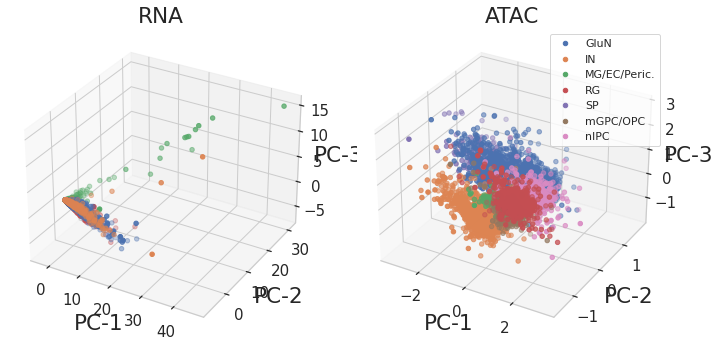

In [12]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-PCA.png')

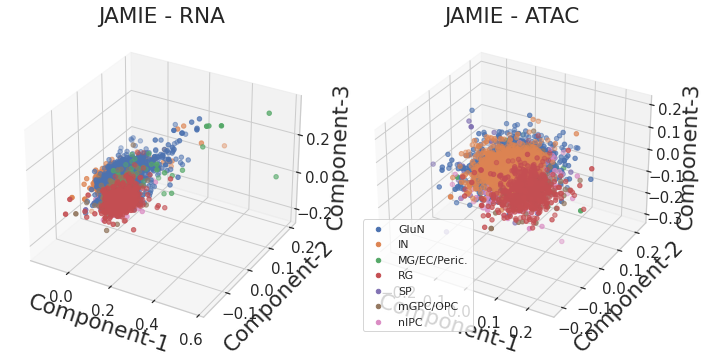

In [42]:
fig = plt.figure(figsize=(10, 5))
plot_integrated(cm_im_data, labels, ['JAMIE - ' + mn for mn in modality_names])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png')

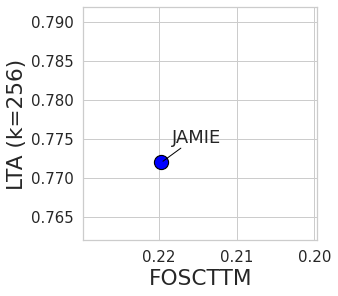

In [49]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph([cm_im_data], labels, [imputed_names[1]], colors=[colors[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Acc.png')

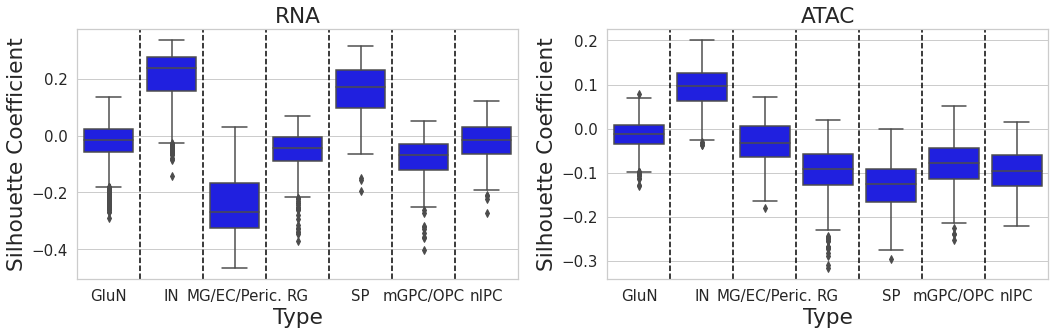

In [50]:
plt.figure(figsize=(15, 5))
plot_silhouette([cm_im_data], labels, [imputed_names[1]], modality_names, colors=[colors[0]])
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Sil.png')

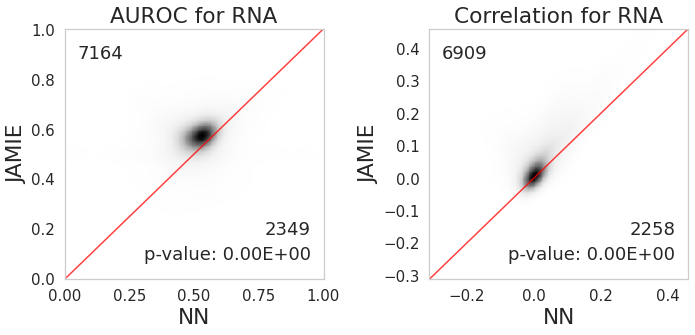

In [13]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png')

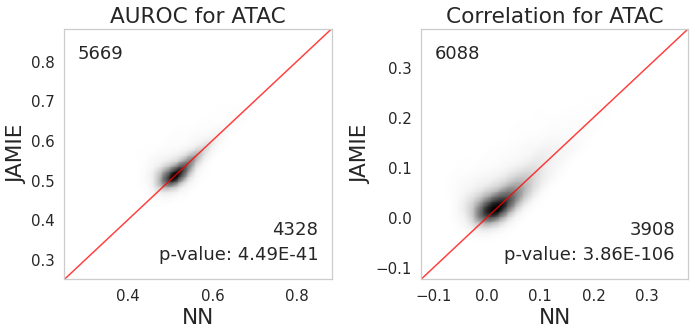

In [14]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png')

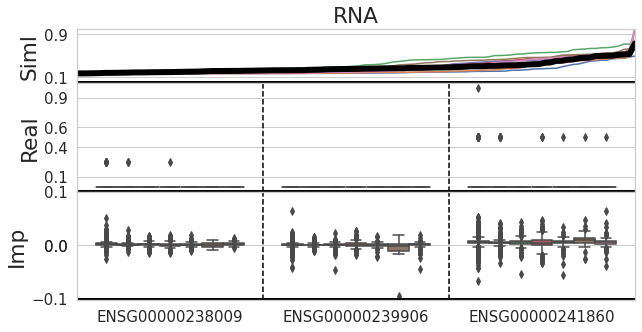

In [15]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png')

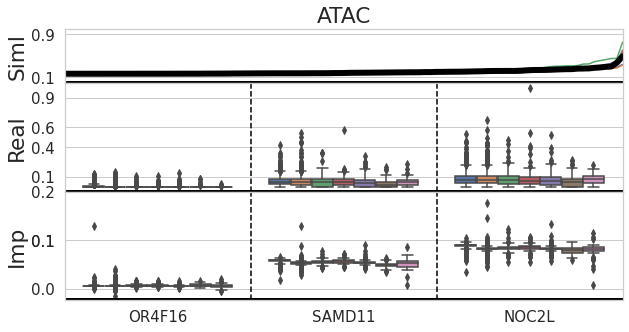

In [16]:
plt.figure(figsize=(10, 5))
plot_distribution([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png')

# Explanation

In [17]:
# RNA (Place) -> ATAC
# SHANK2 (4) -> OR8J3
# ACTA2 (6) -> FAM25C

# ATAC (Place) -> RNA
# PRSS53 (2) -> NAA60
# NOD2 (13) -> NAA60
# BCL7C (17) -> NAA60
#
# SLC30AC (6) -> ERBB4

In [18]:
sns.set(style=style)

In [19]:
mod0, mod1 = 1, 0

In [20]:
dist_sort = np.argsort(np.abs(cm_imputed[mod1] - dataset[mod1][test_idx]).sum(0))
from scipy.stats import pearsonr
corr_arr = np.array([pearsonr(cm_imputed[mod1][:, i], dataset[mod1][test_idx, i])[0] for i in range(dataset[mod1].shape[1])])
corr_sort = np.argsort(corr_arr)[::-1]
temp_order = np.argsort(np.array([np.argwhere(dist_sort==i)[0][0] + np.argwhere(corr_sort==i)[0][0] for i in range(dataset[mod1].shape[1])]))
thresh1, thresh2 = dataset[mod1].mean(0) > 0, np.std(dataset[mod1], 0) > np.percentile(np.std(dataset[mod1], 0), 99.5)
order = [i for i in temp_order if thresh1[i] and thresh2[i]]
order_str = ', '.join([str(n) for n in order[:10]])
print(f'Top candidate features for SHAP: {order_str}')

/home/thema/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Top candidate features for SHAP: 4404, 12359, 1006, 3594, 12344, 11954, 16376, 387, 19707, 18117


In [21]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = order[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

Permutation explainer: 8982it [2:28:07,  1.01it/s]                                                                      


In [22]:
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:20]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

Target RNA Feature: ENSG00000178568
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000178568
Important ATAC Features: LTA, MTFR1L, CSNK1E, HIST1H2AD, LENG8, SLC30A3, CCDC183, CCDC87, STX10, TIPIN, ARID5A, RTN2, KLHDC7B, IFITM5, ZMYND10, APOC1, AL049650.1, MEX3B, WDCP, OVCA2
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LTA
https://www.genecards.org/cgi-bin/carddisp.pl?gene=MTFR1L
https://www.genecards.org/cgi-bin/carddisp.pl?gene=CSNK1E
https://www.genecards.org/cgi-bin/carddisp.pl?gene=HIST1H2AD
https://www.genecards.org/cgi-bin/carddisp.pl?gene=LENG8
https://www.genecards.org/cgi-bin/carddisp.pl?gene=SLC30A3
https://www.genecards.org/cgi-bin/carddisp.pl?gene=CCDC183
https://www.genecards.org/cgi-bin/carddisp.pl?gene=CCDC87
https://www.genecards.org/cgi-bin/carddisp.pl?gene=STX10
https://www.genecards.org/cgi-bin/carddisp.pl?gene=TIPIN
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ARID5A
https://www.genecards.org/cgi-bin/carddisp.pl?gene=RTN2
https://www.genecards.

In [23]:
# targets = ['PRR25']
# for t in targets:
#     print(np.argwhere(importance==t)[0][0])

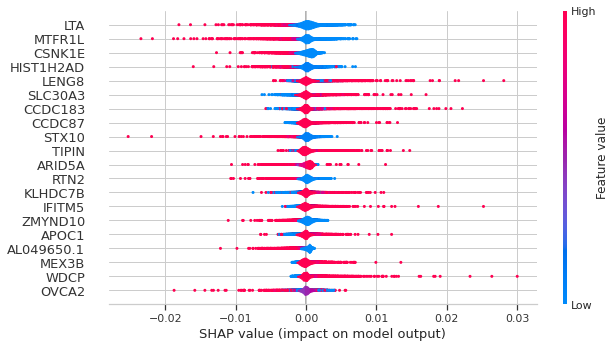

In [24]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=20, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

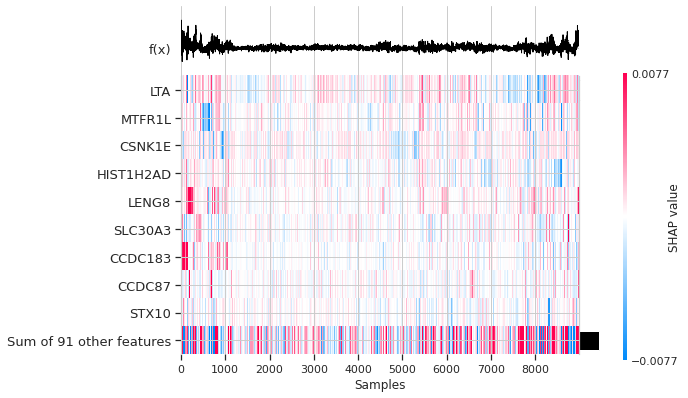

In [25]:
shap.plots.heatmap(shap_values, show=False)
plt.gca().set_xlabel('Samples')
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

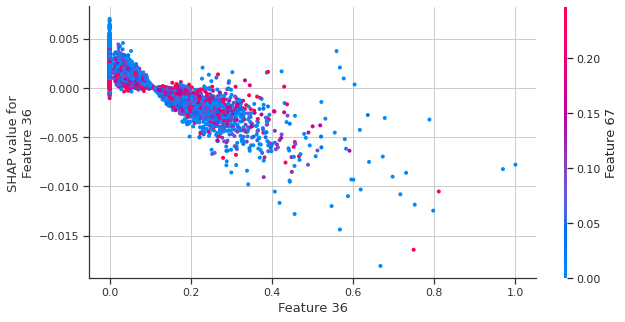

In [26]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

## Interactive

In [ ]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [ ]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [ ]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)